In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from matplotlib import pyplot as plt
from IPython import display 

In [2]:
from code_AVO import SimpleModel, make_optimizer_step, get_gradient_penalty

In [3]:
critic = SimpleModel()

In [4]:
batch_size = 50
learning_rate = 0.001
lambda_gradient = 0.01 # Gradient penalty
lambda_entropy = 1 #5. # Entropy penalty
beta1 = 0.5
beta2 = 0.9
critic_steps = 100
count_steps = 3000

batch_shape = (batch_size, 1)
critic_shape = (batch_size, 1)


In [5]:
proposal_initial_mu = [0., 0.]
proposal_initial_lg_sigma = torch.tensor([0., 0.])


In [6]:
alpha_real, beta_real = 1., -1
z_0 = torch.distributions.Normal(alpha_real, 1.)
z_1 = torch.distributions.Normal(beta_real, 3.)
z_2 = torch.distributions.Normal(0., 1.5)
z_3 = torch.distributions.Exponential(3.)
z_4 = torch.distributions.Exponential(0.5)

z = torch.cat([_z.sample(batch_shape) for _z in [z_0, z_1, z_2, z_3, z_4]], dim=1)
R = torch.tensor(np.eye(5) + np.random.rand(5, 5) * 0.001, dtype=torch.float)
x = torch.matmul(z, R)

In [7]:
def get_data_op():
    z = torch.cat([_z.sample(batch_shape) for _z in [z_0, z_1, z_2, z_3, z_4]], dim=1)
    R = torch.tensor(np.eye(5) + np.random.rand(5, 5) * 0.001, dtype=torch.float)
    x = torch.matmul(z, R)
    return x

In [8]:
mu_0, mu_1 = torch.tensor(0., requires_grad=True), torch.tensor(0., requires_grad=True)
lg_sigma_0, lg_sigma_1 = torch.tensor(0., requires_grad=True), torch.tensor(0., requires_grad=True)

In [10]:
critic = SimpleModel(5)
critic_optimizer = torch.optim.Adam(critic.parameters(), lr=learning_rate, betas=(beta1, beta2))
proposal_optimizer = torch.optim.Adam([mu_0, mu_1, lg_sigma_0, lg_sigma_1], lr=learning_rate, betas=(beta1, beta2))

In [11]:
em_losses = np.zeros(count_steps)
critic_losses = np.zeros(count_steps)
proposal_losses = np.zeros(count_steps)

In [12]:
a = torch.distributions.MultivariateNormal(torch.tensor([1., 1.]), covariance_matrix=torch.eye(2))
a.log_prob(a.sample())

tensor(-1.9099)

Step: 2900, critic_loss = 2.054997205734253


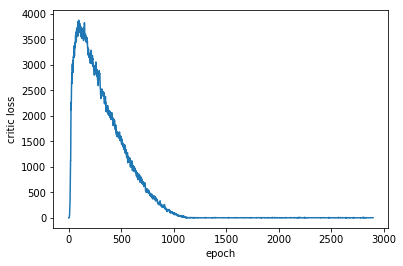

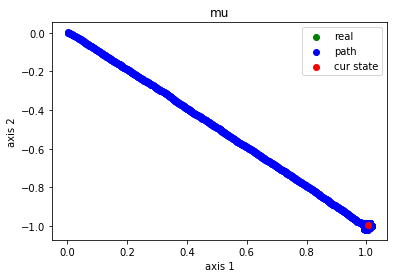

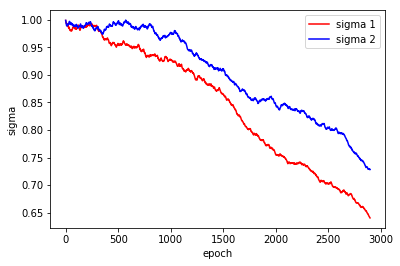

In [13]:
hist_mu = np.zeros((count_steps, 2))
hist_lg_sigma = np.zeros((count_steps, 2))
print('Step 0: mu = {}, sigma = {}'.format([mu_0, mu_1], [torch.exp(lg_sigma_0)]))
_tgp = np.zeros(count_steps)
for epoch in range(0, count_steps):
    _c_l = np.zeros(critic_steps)
    
    for idx in range(0, critic_steps):
        data_op = get_data_op()
        
        proposal_distribution_0 = torch.distributions.Normal(loc=mu_0, 
                                                             scale=torch.exp(lg_sigma_0))
        proposal_distribution_1 = torch.distributions.Normal(loc=mu_1, 
                                                             scale=torch.exp(lg_sigma_1))

        sample_proposal_op_0 = proposal_distribution_0.sample(torch.Size(batch_shape))
        sample_proposal_op_1 = proposal_distribution_1.sample(torch.Size(batch_shape))

        lg_proposal_op_0 = proposal_distribution_0.log_prob(sample_proposal_op_0)
        lg_proposal_op_1 = proposal_distribution_1.log_prob(sample_proposal_op_1)


        

        z_0_p = torch.distributions.Normal(sample_proposal_op_0, scale=1.)
        z_1_p = torch.distributions.Normal(sample_proposal_op_1, scale=3.)

        z_s = torch.cat([_z.sample() for _z in [z_0_p, z_1_p]] +
                        [_z.sample(batch_shape) for _z in [z_2, z_3, z_4]], dim=1)
        
        simulate_op = torch.matmul(z_s, R)

        critic_data = critic(data_op)
        critic_fake = critic(simulate_op)

        gradient_penalty = get_gradient_penalty(data_op, simulate_op, critic)
        critic_loss = torch.mean(critic_fake - critic_data + lambda_gradient * gradient_penalty)

        make_optimizer_step(critic_loss, critic_optimizer)
    
    _tgp[epoch] = gradient_penalty
    critic_loss = torch.mean(critic_fake - critic_data + gradient_penalty)
    critic_losses[epoch] = critic_loss
    
    proposal_distribution_0 = torch.distributions.Normal(loc=mu_0, 
                                                         scale=torch.exp(lg_sigma_0))
    proposal_distribution_1 = torch.distributions.Normal(loc=mu_1, 
                                                         scale=torch.exp(lg_sigma_1))

    sample_proposal_op_0 = proposal_distribution_0.sample(torch.Size(batch_shape))
    sample_proposal_op_1 = proposal_distribution_1.sample(torch.Size(batch_shape))

    lg_proposal_op_0 = proposal_distribution_0.log_prob(sample_proposal_op_0)
    lg_proposal_op_1 = proposal_distribution_1.log_prob(sample_proposal_op_1)

    z_0_p = torch.distributions.Normal(sample_proposal_op_0, scale=1.)
    z_1_p = torch.distributions.Normal(sample_proposal_op_1, scale=3.)

    z_s = torch.cat([_z.sample() for _z in [z_0_p, z_1_p]] +
                    [_z.sample(batch_shape) for _z in [z_2, z_3, z_4]], dim=1)

    simulate_op = torch.matmul(z_s, R)
    
    critic_fake = critic(simulate_op)

    loss_proposal = torch.mean(-critic_fake * (lg_proposal_op_0 + lg_proposal_op_1) +
                               lambda_entropy * (lg_sigma_0 + lg_sigma_1))
    proposal_losses[epoch] = loss_proposal

    make_optimizer_step(loss_proposal, proposal_optimizer, retain_graph=True)
    
    hist_mu[epoch] = np.array([mu_0, mu_1])
    hist_lg_sigma[epoch] = np.array([lg_sigma_0, lg_sigma_1])
    if epoch%100 == 0:
        display.clear_output()
        print('Step: {}, critic_loss = {}'.format(epoch, critic_loss))
        
        plt.plot(critic_losses[:epoch])
        plt.xlabel('epoch')
        plt.ylabel('critic loss')

        plt.figure()
        plt.scatter(alpha_real, beta_real, color='g', label='real')
        plt.scatter(hist_mu[:epoch, 0], hist_mu[:epoch, 1], color='b', label='path')
        plt.scatter(hist_mu[epoch-1, 0], hist_mu[epoch-1, 1], color='r', label='cur state')
        plt.xlabel('axis 1')
        plt.ylabel('axis 2')
        plt.title('mu')
        plt.legend()

        plt.figure()
        plt.plot(np.exp(hist_lg_sigma[:epoch, 0]), color='r', label='sigma 1')
        plt.plot(np.exp(hist_lg_sigma[:epoch, 1]), color='b', label='sigma 2')
        plt.xlabel('epoch')
        plt.ylabel('sigma')
        plt.legend()

        plt.show()

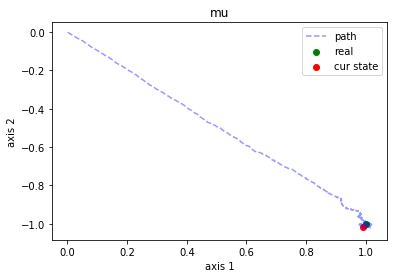

In [96]:
plt.figure()
plt.scatter(alpha_real, beta_real, color='g', label='real')
plt.plot(hist_mu[:epoch, 0], hist_mu[:epoch, 1], 'b--', alpha=0.4, label='path')
plt.scatter(hist_mu[epoch-1, 0], hist_mu[epoch-1, 1], color='r', label='cur state')
plt.xlabel('axis 1')
plt.ylabel('axis 2')
plt.title('mu')
plt.legend()

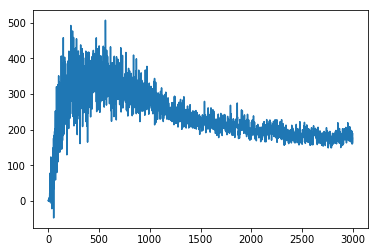

In [98]:
plt.plot(proposal_losses)